# 📈 LSTM株価予測モデル - トヨタ自動車（7203.T）

このノートブックは、LSTMニューラルネットワークを使ってトヨタ自動車の株価を予測します。

## 📋 実行手順

1. **ライブラリのインストール** → 実行時間: 約1分
2. **データ取得** → 実行時間: 約30秒
3. **モデル訓練** → 実行時間: 約5～10分
4. **予測と可視化** → 実行時間: 約30秒

## ⚠️ 注意事項

このプログラムは**教育・学習目的**です。実際の投資判断には使用しないでください。

---

## 1️⃣ ライブラリのインストール

必要なPythonライブラリをインストールします。
（Google Colabには既にインストールされているものもあります）

In [1]:
# 必要なライブラリをインストール
!pip install yfinance -q

print("✓ ライブラリのインストールが完了しました！")

✓ ライブラリのインストールが完了しました！


## 2️⃣ ライブラリのインポート

必要なライブラリをすべてインポートします。

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# グラフの設定
plt.rcParams['figure.figsize'] = (15, 6)
%matplotlib inline

print("✓ ライブラリのインポートが完了しました！")

✓ ライブラリのインポートが完了しました！


## 3️⃣ パラメータ設定

モデルの各種パラメータを設定します。

In [26]:
# === 設定パラメータ ===

# 株式銘柄
TICKER = "7203.T"  # トヨタ自動車

# データ取得期間
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5*365)  # 過去5年分

# モデルパラメータ
LOOK_BACK = 60  # 過去60日分のデータを使って予測
TRAIN_RATIO = 0.8  # データの80%を訓練用、20%をテスト用に
EPOCHS = 50  # トレーニング回数
BATCH_SIZE = 32  # バッチサイズ

print("✓ パラメータ設定完了")
print(f"  銘柄: {TICKER}")
print(f"  期間: {START_DATE.date()} ～ {END_DATE.date()}")
print(f"  過去参照日数: {LOOK_BACK}日")

✓ パラメータ設定完了
  銘柄: 7203.T
  期間: 2021-01-20 ～ 2026-01-19
  過去参照日数: 60日


## 4️⃣ データ取得

Yahoo Financeからトヨタ自動車の株価データを取得します。

In [27]:
print(f"\n{'='*60}")
print(f"株価データを取得中: {TICKER}")
print(f"期間: {START_DATE.date()} ～ {END_DATE.date()}")
print(f"{'='*60}\n")

# yfinanceを使ってデータをダウンロード
stock_data = yf.download(TICKER, start=START_DATE, end=END_DATE)

if stock_data.empty:
    print("エラー: データが取得できませんでした。")
else:
    print(f"✓ {len(stock_data)}日分のデータを取得しました！\n")

    # データの最初の5行を表示
    print("【最初の5行】")
    print(stock_data.head())
    print()

    # 統計情報を表示
    print("【終値の統計情報】")
    print(stock_data['Close'].describe())


株価データを取得中: 7203.T
期間: 2021-01-20 ～ 2026-01-19



[*********************100%***********************]  1 of 1 completed

✓ 1221日分のデータを取得しました！

【最初の5行】
Price             Close         High          Low         Open    Volume
Ticker           7203.T       7203.T       7203.T       7203.T    7203.T
Date                                                                    
2021-01-20  1332.734741  1339.150478  1318.862925  1336.549512  22139500
2021-01-21  1342.791870  1355.623237  1337.243122  1338.283466  26310000
2021-01-22  1328.226440  1343.485418  1328.226440  1335.162349  22639500
2021-01-25  1331.174438  1332.041427  1321.984380  1332.041427  19970000
2021-01-26  1300.482788  1315.741765  1300.482788  1308.285685  34543000

【終値の統計情報】
Ticker       7203.T
count   1221.000000
mean    2281.504171
std      576.619248
min     1264.762939
25%     1790.490479
50%     2160.160400
75%     2689.254150
max     3714.000000


## 5️⃣ データの可視化

取得したデータをグラフで確認します。

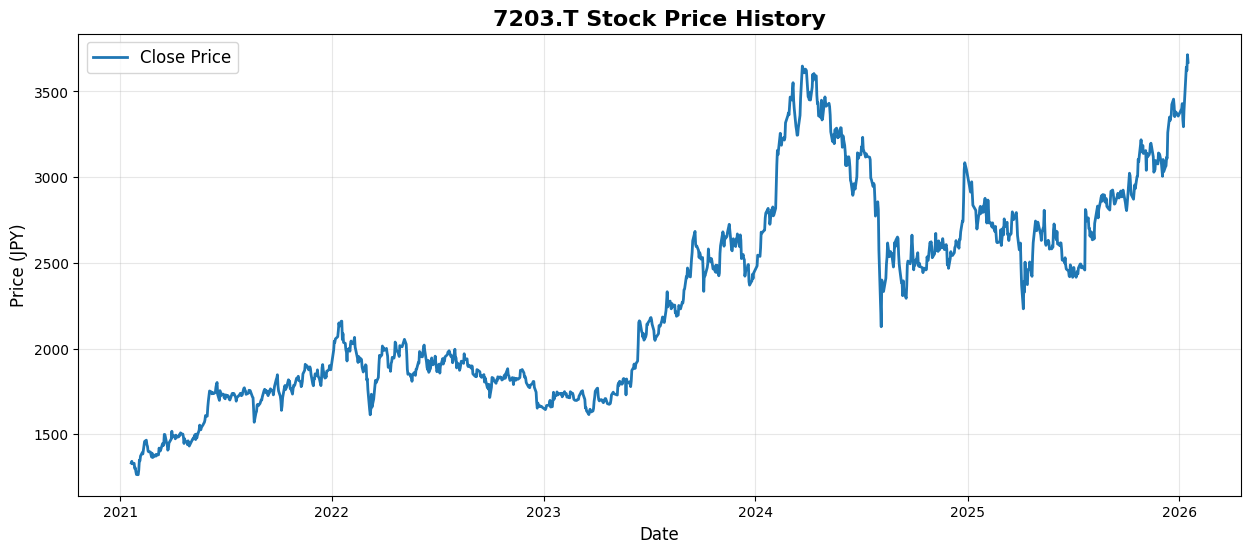

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', linewidth=2)
plt.title(f'{TICKER} Stock Price History', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (JPY)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 6️⃣ データ前処理

データを正規化して、LSTM用の形式に変換します。

In [29]:
print("【データの前処理】\n")

# 終値（Close）のデータだけを使用
close_prices = stock_data['Close'].values.reshape(-1, 1)
print(f"1. 終値データを抽出: {len(close_prices)}日分")

# データの正規化（0～1の範囲に変換）
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)
print(f"2. データを正規化（0～1の範囲）")

# データを訓練用とテスト用に分割
train_size = int(len(scaled_data) * TRAIN_RATIO)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - LOOK_BACK:]
print(f"3. データ分割:")
print(f"   - 訓練用: {len(train_data)}日分")
print(f"   - テスト用: {len(test_data) - LOOK_BACK}日分")

# LSTM用のデータ形式に変換
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_data, LOOK_BACK)
X_test, y_test = create_dataset(test_data, LOOK_BACK)

# LSTMの入力形式に変換: [サンプル数, タイムステップ, 特徴量]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"4. LSTM用データ形式に変換")
print(f"   - 訓練データ形状: {X_train.shape}")
print(f"   - テストデータ形状: {X_test.shape}")
print("\n✓ データ前処理完了！")

【データの前処理】

1. 終値データを抽出: 1221日分
2. データを正規化（0～1の範囲）
3. データ分割:
   - 訓練用: 976日分
   - テスト用: 245日分
4. LSTM用データ形式に変換
   - 訓練データ形状: (916, 60, 1)
   - テストデータ形状: (245, 60, 1)

✓ データ前処理完了！


## 7️⃣ LSTMモデルの構築

3層のLSTMニューラルネットワークを構築します。

In [30]:
print("【モデルの構築】\n")

model = Sequential([
    # 第1層: LSTM（50ユニット）
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),  # 過学習を防ぐ

    # 第2層: LSTM（50ユニット）
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),

    # 第3層: LSTM（50ユニット）
    LSTM(units=50),
    Dropout(0.2),

    # 出力層: 予測値（1つ）
    Dense(units=1)
])

# モデルのコンパイル
model.compile(optimizer='adam', loss='mean_squared_error')

print("モデル構造:")
model.summary()
print("\n✓ モデル構築完了！")

【モデルの構築】

モデル構造:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)


✓ モデル構築完了！


## 8️⃣ モデルのトレーニング

LSTMモデルをトレーニングします。（この処理には5～10分かかります）

In [31]:
print("【モデルのトレーニング】")
print(f"エポック数: {EPOCHS}")
print(f"バッチサイズ: {BATCH_SIZE}")
print("\nトレーニング開始...\n")

# Early Stopping（学習が改善しなくなったら自動停止）
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# トレーニング実行
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

print("\n✓ トレーニング完了！")

【モデルのトレーニング】
エポック数: 50
バッチサイズ: 32

トレーニング開始...

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0506 - val_loss: 0.0153
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 12/50
29/

## 9️⃣ トレーニング履歴の可視化

学習の進捗をグラフで確認します。

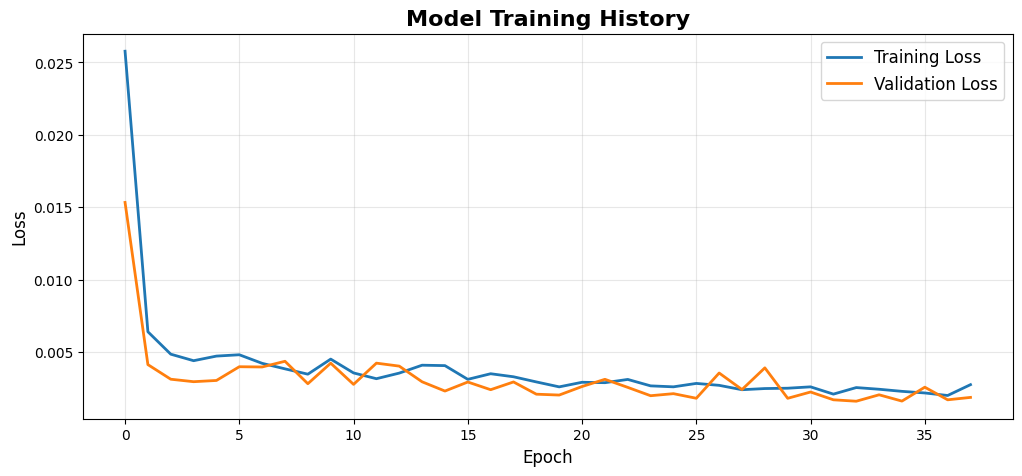

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Training History', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 🔟 株価予測の実行

訓練したモデルを使って株価を予測します。

In [33]:
print("【予測実行】\n")

# 予測実行
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# 実際の株価
actual_prices = close_prices[train_size:]
dates = stock_data.index[train_size:]

print(f"✓ {len(predictions)}日分の株価を予測しました\n")

【予測実行】



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
✓ 245日分の株価を予測しました



## 1️⃣1️⃣ 予測精度の評価

予測の精度を計算します。

In [34]:
# 評価指標を計算
rmse = np.sqrt(np.mean((actual_prices - predictions) ** 2))
mae = np.mean(np.abs(actual_prices - predictions))
mape = np.mean(np.abs((actual_prices - predictions) / actual_prices)) * 100

print("【予測精度】")
print(f"  RMSE (二乗平均平方根誤差): {rmse:.2f} 円")
print(f"  MAE  (平均絶対誤差):        {mae:.2f} 円")
print(f"  MAPE (平均絶対誤差率):      {mape:.2f} %")
print("\n※ 数値が小さいほど精度が高いです")

【予測精度】
  RMSE (二乗平均平方根誤差): 98.64 円
  MAE  (平均絶対誤差):        74.98 円
  MAPE (平均絶対誤差率):      2.68 %

※ 数値が小さいほど精度が高いです


## 1️⃣2️⃣ 予測結果の可視化（全期間）

実際の株価と予測結果を比較します。

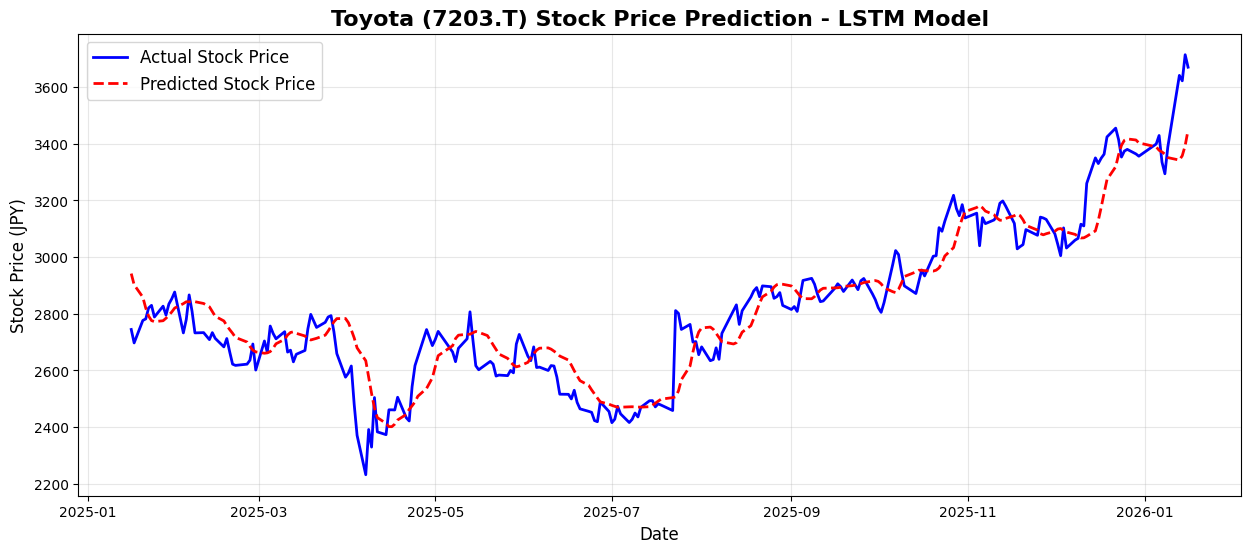

In [35]:
plt.figure(figsize=(15, 6))

# 実際の株価
plt.plot(dates, actual_prices, label='Actual Stock Price', color='blue', linewidth=2)

# 予測された株価
plt.plot(dates, predictions, label='Predicted Stock Price', color='red',
         linewidth=2, linestyle='--')

plt.title('Toyota (7203.T) Stock Price Prediction - LSTM Model',
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (JPY)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 1️⃣3️⃣ 予測結果の可視化（直近60日）

最近のデータを拡大して表示します。

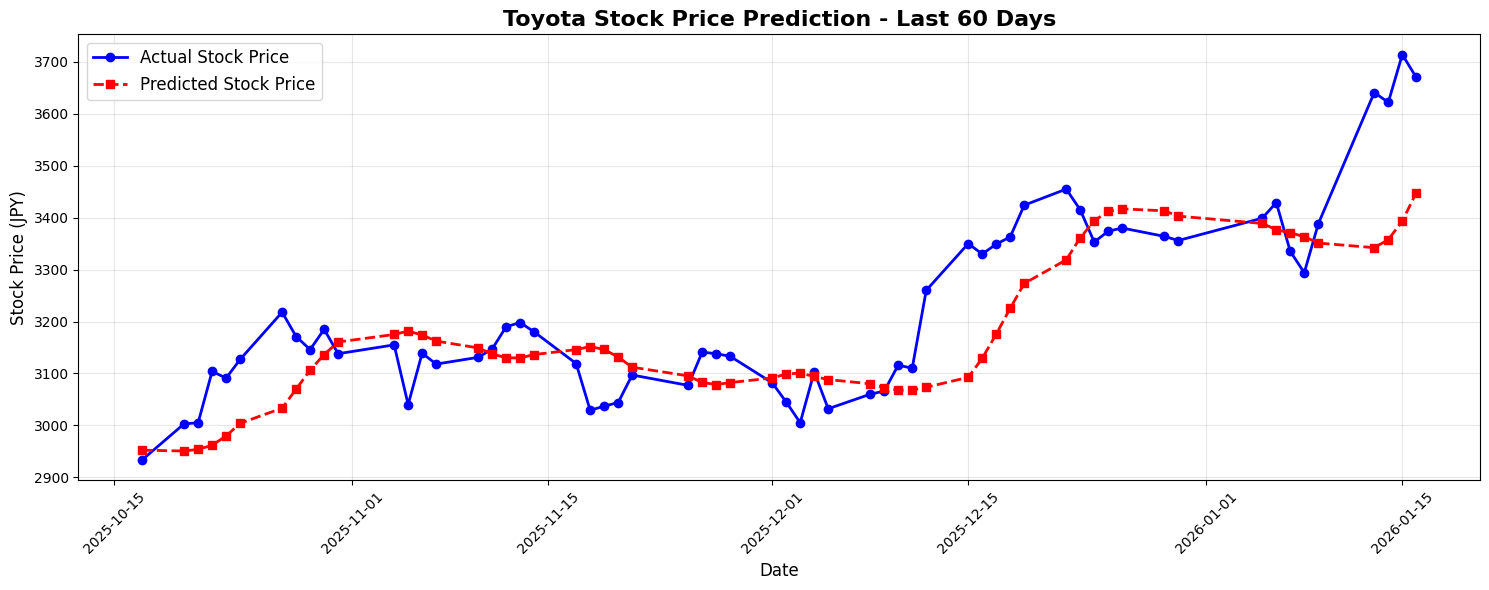

In [36]:
# 最近60日のデータのみ抽出
days = 60
recent_dates = dates[-days:]
recent_actual = actual_prices[-days:]
recent_predicted = predictions[-days:]

plt.figure(figsize=(15, 6))

# 実際の株価
plt.plot(recent_dates, recent_actual, label='Actual Stock Price',
         color='blue', linewidth=2, marker='o')

# 予測された株価
plt.plot(recent_dates, recent_predicted, label='Predicted Stock Price',
         color='red', linewidth=2, marker='s', linestyle='--')

plt.title(f'Toyota Stock Price Prediction - Last {days} Days',
          fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price (JPY)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ✅ 完了！

すべての処理が完了しました。

### 📝 結果のまとめ

- データ取得: 完了
- モデル訓練: 完了
- 株価予測: 完了
- 可視化: 完了

### 🔄 カスタマイズ方法

**別の銘柄で試したい場合**は、セル3の`TICKER`を変更してください：
- ソニー: `TICKER = "6758.T"`
- 任天堂: `TICKER = "7974.T"`
- ソフトバンク: `TICKER = "9984.T"`

変更後、セル3から順に再実行してください。

---

**⚠️ 免責事項**: このモデルは教育・学習目的です。実際の投資判断には使用しないでください。